In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import os
import re
import json
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pprint import pprint
from IPython.display import Audio
from scipy.io import wavfile

from bark.bark import SAMPLE_RATE, generate_audio, preload_models

In [2]:
def save_history(basepath: str, audio_array: np.ndarray, prompt: str, generation_data: list):
  np.savez(f"{basepath}.npz", semantic_prompt=generation_data[0], coarse_prompt=generation_data[1], fine_prompt=generation_data[2])
  with open(f"{basepath}.txt", "w", encoding="utf-8") as fp: fp.write(prompt)
  wavfile.write(f"{basepath}.wav", SAMPLE_RATE, audio_array)

def load_history(filepath: str):
  return np.load(filepath)

def load_voice(filepath: str):
  sample_rate, audio_array = wavfile.read(filepath)
  return audio_array

In [3]:
NUM_EPOCHS = 1
NUM_STEPS = 50000

BATCH_SIZE = 4

DURATION = 3000

EMBEDDING_DIM = int(DURATION * SAMPLE_RATE / 1000)

In [4]:
class VoiceDataset(Dataset):
  def __init__(self, directory, embedding_dim = EMBEDDING_DIM):
    super().__init__()
    self.k = 1
    self.population = 0
    self.length = 0
    self.embedding_dim = embedding_dim
    self.voices = []
    self.base_map = {}
    for filename in os.listdir(directory):
      if not filename.endswith(".wav"): continue
      self.voices.append([])
      self.population += 1
      folder_name = filename.split(".wav")[0]
      self.base_map[folder_name] = self.population
      for fn in os.listdir(f"./data/bark/{folder_name}"):
        if not fn.endswith(".wav"): continue
        self.voices[-1].append(load_voice(f"./data/bark/{folder_name}/{fn}"))
        self.length += 1

  def __getitem__(self, _):
    samples, targets, labels = [], [], torch.zeros(len(self.voices))
    r_index = random.randint(0, len(self.voices) - 1)
    labels[r_index] = 1
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(s[r:r + self.embedding_dim])
      for t in random.choices(self.voices[r_index], k=self.k):
        r = random.randint(0, len(t) - self.embedding_dim)
        targets.append(t[r:r + self.embedding_dim])
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, -1).float()
    return samples, targets, labels

  def get_selected(self, target):
    samples, targets = [], []
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(s[r:r + self.embedding_dim])
        r = random.randint(0, len(target) - self.embedding_dim)
        targets.append(target[r:r + self.embedding_dim])
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, -1).float()
    return samples, targets

  def __len__(self): return self.length

In [6]:
dataset = VoiceDataset("./data/bark")
torch.save(dataset, "./checkpoints/bark_dataset.pt")

In [7]:
dataset = torch.load("./checkpoints/bark_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [8]:
class Judge(nn.Module):
  def __init__(self, k):
    super().__init__()
    self.k = k
    self.seq1 = nn.Sequential(
      nn.Conv1d(1, 64, int(0.025 * SAMPLE_RATE), int(0.01 * SAMPLE_RATE)),
      nn.BatchNorm1d(64),
      nn.MaxPool1d(4),
      nn.ReLU(True),
      nn.Conv1d(64, 128, 4),
      nn.BatchNorm1d(128),
      nn.MaxPool1d(2),
      nn.ReLU(True),
      nn.Conv1d(128, 256, 4),
      nn.BatchNorm1d(256),
      nn.MaxPool1d(2),
      nn.ReLU(True)
    )
    self.gru = nn.LSTM(256, 256, 2, batch_first=True, bidirectional=True)
    self.seq2 = nn.Sequential(
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.3)
    )
    self.seq3 = nn.Sequential(
      nn.Linear(256 * 64, 1024),
      nn.ReLU(True),
      nn.Dropout(0.2),
      nn.Linear(1024, 256),
      nn.ReLU(True),
      nn.Dropout(0.1),
      nn.Linear(256, 64),
      nn.ReLU(True),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )

  def forward(self, sample, target):
    outputs1 = self.seq1(sample.view(-1, 1, sample.size(1)))
    outputs2 = self.seq1(target.view(-1, 1, target.size(1)))
    outputs1, _ = self.gru(outputs1.permute(0, 2, 1))
    outputs2, _ = self.gru(outputs2.permute(0, 2, 1))
    outputs1 = self.seq2(outputs1)
    outputs2 = self.seq2(outputs2)
    outputs = self.seq3(torch.cat((outputs1, outputs2), dim=1))
    outputs = torch.cat([outputs[i:i + self.k, :] for i in range(0, outputs.size(0), self.k)], dim=1).sum(0)
    return outputs

class Model(nn.Module):
  def __init__(self, k = 1):
    super().__init__()
    self.k = k
    self.judge = Judge(self.k)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, samples, targets):
    outputs = []
    for s, t in zip(samples, targets): outputs.append(self.judge(s, t).unsqueeze(1))
    outputs = torch.cat(tuple(outputs), dim=1).permute(1, 0)
    outputs = self.softmax(outputs)
    return outputs

In [9]:
samples, targets, labels = next(iter(dataloader))
model = Judge()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][0].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][1].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][2].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), targets[0][0].numpy())
plt.show()
print(model(samples[0], targets[0]))
print(model(samples[1], targets[1]))

TypeError: Judge.__init__() missing 1 required positional argument: 'k'

In [10]:
samples, targets, labels = next(iter(dataloader))
model = Model(dataset.k)
loss_fn = nn.CrossEntropyLoss()
outputs = model(samples, targets)
print(samples.shape, targets.shape)
print(outputs)
print(labels)
print(loss_fn(outputs, labels))

torch.Size([4, 10, 72000]) torch.Size([4, 10, 72000])
tensor([[0.0999, 0.1000, 0.1001, 0.1001, 0.0999, 0.1000, 0.1000, 0.1001, 0.1000,
         0.1000],
        [0.1000, 0.0999, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.0999, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.0999, 0.0999, 0.1000, 0.1001, 0.1000, 0.1000, 0.1000, 0.1001, 0.1000,
         0.0999]], grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
tensor(2.3026, grad_fn=<DivBackward1>)


In [11]:
for _ in tqdm(range(100)): samples, targets, labels = next(iter(dataloader))

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [12]:
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(dataset.k)
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
losses = []

model.train()

if device == "cuda": model.cuda()
for step in range(1, NUM_STEPS + 1):
  optimizer.zero_grad()
  samples, targets, labels = next(iter(dataloader))
  outputs = model(samples.to(device), targets.to(device))
  loss = loss_fn(outputs.to(device), labels.to(device))
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  if step % 100 == 0:
    print(f"{step}/{NUM_STEPS}:\t{np.mean(losses):.4f}")
    losses = []
print("Training Ended!")

100/50000:	2.3026
200/50000:	2.3026
300/50000:	2.3026
400/50000:	2.3026
500/50000:	2.3026
600/50000:	2.3024
700/50000:	2.2999
800/50000:	2.2923
900/50000:	2.2836
1000/50000:	2.2864
1100/50000:	2.2762
1200/50000:	2.2768
1300/50000:	2.2738
1400/50000:	2.2695
1500/50000:	2.2673
1600/50000:	2.2642
1700/50000:	2.2564
1800/50000:	2.2534
1900/50000:	2.2520
2000/50000:	2.2476
2100/50000:	2.2467
2200/50000:	2.2442
2300/50000:	2.2398
2400/50000:	2.2433
2500/50000:	2.2433
2600/50000:	2.2421
2700/50000:	2.2431
2800/50000:	2.2403
2900/50000:	2.2383
3000/50000:	2.2377
3100/50000:	2.2373
3200/50000:	2.2359
3300/50000:	2.2340
3400/50000:	2.2384
3500/50000:	2.2369
3600/50000:	2.2353
3700/50000:	2.2314
3800/50000:	2.2326
3900/50000:	2.2299
4000/50000:	2.2308
4100/50000:	2.2322
4200/50000:	2.2308
4300/50000:	2.2296
4400/50000:	2.2294
4500/50000:	2.2303
4600/50000:	2.2304
4700/50000:	2.2376
4800/50000:	2.2287
4900/50000:	2.2268
5000/50000:	2.2267
5100/50000:	2.2262
5200/50000:	2.2304
5300/50000:	2.2280
54

In [ ]:
with torch.no_grad():
  t = load_voice("./data/bark/man-2.wav")
  samples, targets = dataset.get_selected(t)
  outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
  print(np.round(outputs.cpu().numpy(), 3))
  print(outputs.cpu().numpy().argmax() + 1)
  pprint(dataset.base_map)
  display(Audio(samples[0], rate=SAMPLE_RATE))
  display(Audio(targets[0], rate=SAMPLE_RATE))
  display(Audio(samples[1], rate=SAMPLE_RATE))
  display(Audio(targets[1], rate=SAMPLE_RATE))
  # display(Audio(samples[2], rate=SAMPLE_RATE))
  # display(Audio(targets[2], rate=SAMPLE_RATE))

10


100%|██████████| 1000/1000 [00:14<00:00, 71.13it/s]


array([[0.20846986, 0.08443506, 0.08480423, 0.11026284, 0.08953947,
        0.08473878, 0.08443506, 0.08443506, 0.08443506, 0.08444456]])

array([892.,   0.,   2.,  87.,  18.,   1.,   0.,   0.,   0.,   0.])

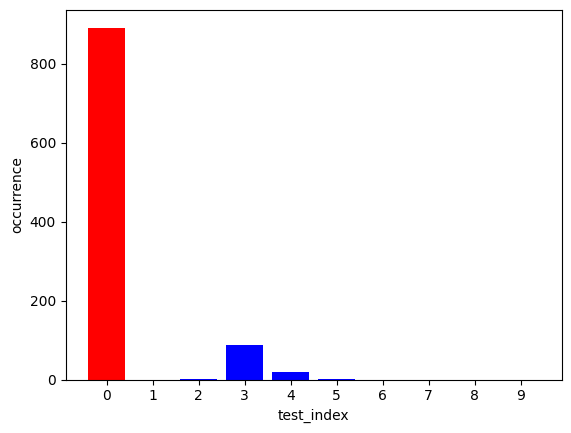

100%|██████████| 1000/1000 [00:13<00:00, 72.69it/s]


array([[0.07514576, 0.20397796, 0.19485588, 0.07514576, 0.07514576,
        0.07514576, 0.07514576, 0.07514576, 0.07514576, 0.07514576]])

array([  0., 991.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

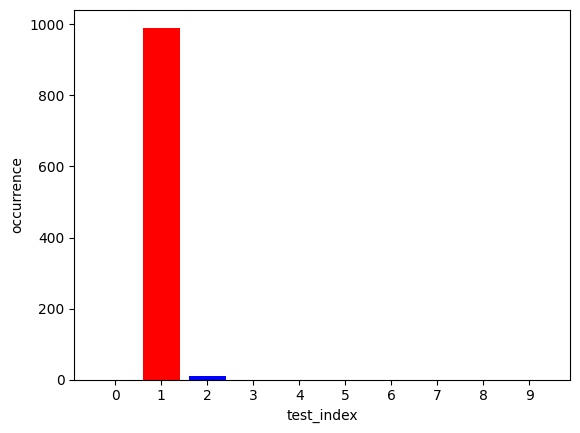

100%|██████████| 1000/1000 [00:13<00:00, 71.44it/s]


array([[0.07542179, 0.20046839, 0.19647768, 0.07503786, 0.07740492,
        0.07503786, 0.07503786, 0.07503786, 0.07503786, 0.07503786]])

array([  1., 969.,  29.,   0.,   1.,   0.,   0.,   0.,   0.,   0.])

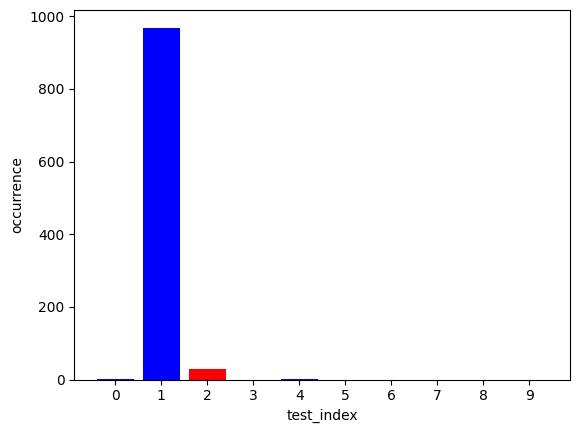

100%|██████████| 1000/1000 [00:14<00:00, 70.54it/s]


array([[0.09380149, 0.08479578, 0.08479578, 0.22618659, 0.08503135,
        0.08620589, 0.08479578, 0.08479578, 0.08479578, 0.08479578]])

array([ 24.,   0.,   0., 971.,   0.,   5.,   0.,   0.,   0.,   0.])

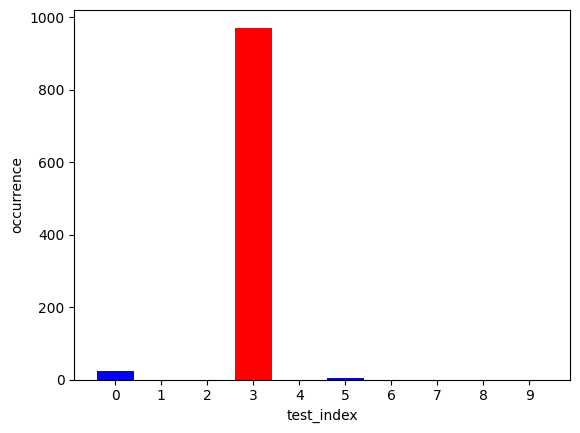

100%|██████████| 1000/1000 [00:14<00:00, 71.32it/s]


array([[0.08774491, 0.08573605, 0.08930135, 0.08560836, 0.22356758,
        0.08560836, 0.08560836, 0.08560836, 0.08560836, 0.08560836]])

array([ 20.,   0.,  17.,   0., 963.,   0.,   0.,   0.,   0.,   0.])

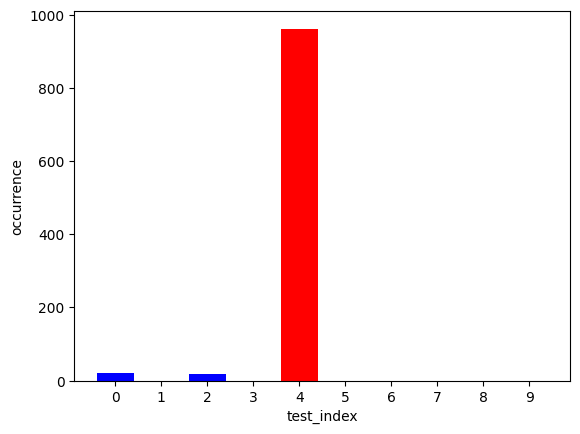

100%|██████████| 1000/1000 [00:14<00:00, 68.77it/s]


array([[0.0855954 , 0.08519383, 0.08519384, 0.08608038, 0.08544068,
        0.22534573, 0.08545062, 0.08530721, 0.08869868, 0.08769364]])

array([  2.,   0.,   0.,  11.,   1., 949.,   2.,   1.,  19.,  15.])

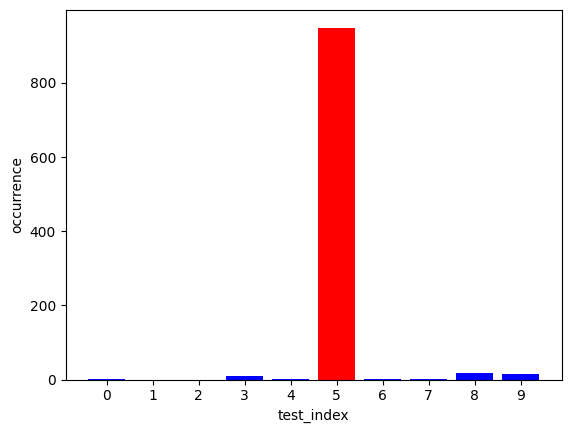

100%|██████████| 1000/1000 [00:14<00:00, 70.96it/s]


array([[0.07344682, 0.07314134, 0.07349361, 0.07314134, 0.07380429,
        0.07353177, 0.15128449, 0.1473604 , 0.13229166, 0.12850425]])

array([  7.,   0.,   3.,   0.,   4.,   3., 555., 199., 179.,  50.])

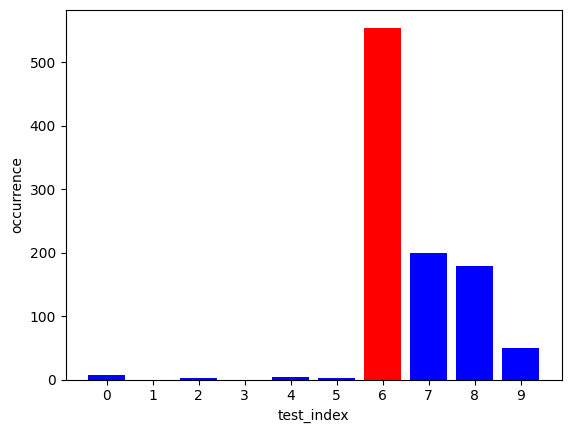

100%|██████████| 1000/1000 [00:13<00:00, 71.85it/s]


array([[0.07500483, 0.07500483, 0.07500483, 0.07500483, 0.07500483,
        0.07500483, 0.1948389 , 0.20297091, 0.07642396, 0.07573718]])

array([  0.,   0.,   0.,   0.,   0.,   0., 926.,  74.,   0.,   0.])

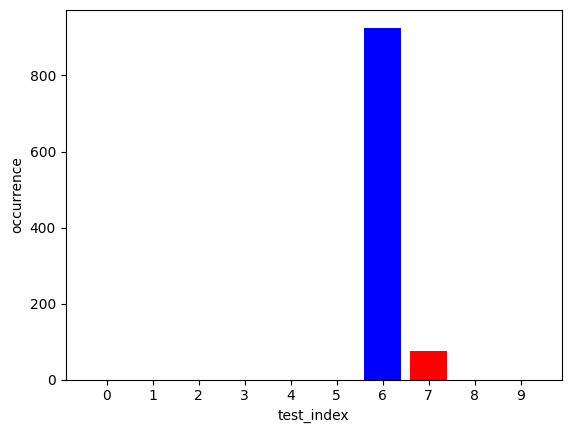

100%|██████████| 1000/1000 [00:14<00:00, 70.15it/s]


array([[0.07838507, 0.07531152, 0.07658166, 0.08360682, 0.07600404,
        0.09634843, 0.0805073 , 0.07586351, 0.17776429, 0.17962733]])

array([ 16.,   0.,   8.,  25.,   5.,  49.,  29.,   1., 606., 261.])

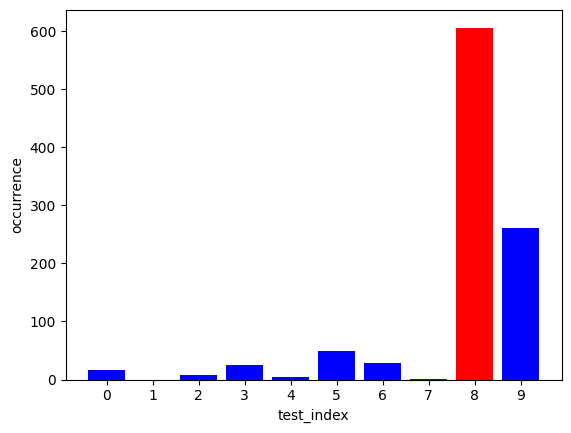

100%|██████████| 1000/1000 [00:13<00:00, 72.01it/s]


array([[0.07368678, 0.07334664, 0.07448046, 0.07334664, 0.07381127,
        0.07631449, 0.08279084, 0.07463175, 0.19826636, 0.19932473]])

array([  3.,   0.,  10.,   0.,   4.,  16.,  66.,   8., 855.,  38.])

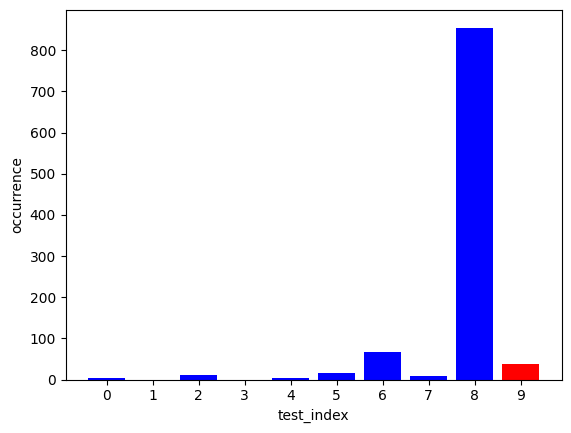

In [22]:
num_validation = 1000
test_cases = ["man-1", "man-2", "man-3", "man-4", "man-5", "woman-1", "woman-2", "woman-3", "woman-4", "woman-5"]
from tqdm import tqdm
print(len(dataset.voices))
with torch.no_grad():
  for test_index in range(len(dataset.voices)):
    colors = ["b" if i != test_index else "r" for i in range(len(dataset.voices))]
    avg = np.zeros((1, len(dataset.voices)))
    occurrences = np.zeros(len(dataset.voices))
    for i in tqdm(range(num_validation)):
      t = load_voice(f"./data/bark/{test_cases[test_index]}.wav")
      samples, targets = dataset.get_selected(t)
      outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
      avg += outputs.cpu().numpy()
      occurrences[outputs.cpu().numpy().argmax()] += 1
    display(avg / num_validation)
    display(occurrences)
    plt.bar(np.arange(len(dataset.voices)), occurrences, color=colors)
    plt.xticks(range(len(dataset.voices)))
    plt.xlabel("test_index")
    plt.ylabel("occurrence")
    plt.show()
  # display(Audio(samples[0], rate=SAMPLE_RATE))
  # display(Audio(targets[0], rate=SAMPLE_RATE))
  # display(Audio(samples[1], rate=SAMPLE_RATE))
  # display(Audio(targets[1], rate=SAMPLE_RATE))
  # display(Audio(samples[2], rate=SAMPLE_RATE))
  # display(Audio(targets[2], rate=SAMPLE_RATE))

In [ ]:
torch.save(model,"./checkpoints/model.pt")

In [ ]:
preload_models(use_smaller_models=True)

In [ ]:
def generate(basename, raw_prompt, index):
  basepath = "./data/bark/"
  text_prompt = re.sub(r"\s\s+", " ", re.sub(r"[\t\n]", "", raw_prompt)).strip()
  print(f"{basename}: prompt-{index}")
  audio_array, generation_data = generate_audio(text_prompt, basename)
  if basename not in os.listdir(basepath): os.mkdir(f"{basepath}/{basename}")
  save_history(f"{basepath}/{basename}/prompt-{index}", audio_array, text_prompt, generation_data)

In [ ]:
with open("./prompts.json") as fp: raw_prompts = json.load(fp)
len(raw_prompts)

In [ ]:
prompt = "Bark was developed for research purposes. It is not a conventional text-to-speech model but instead a fully generative text-to-audio model, which can deviate in unexpected ways from provided prompts."
audio_array, generation_data = generate_audio(prompt)
Audio(audio_array, rate=SAMPLE_RATE)

In [ ]:
save_history("./data/bark/woman-4", audio_array, prompt, generation_data)